# TOI 519.01 TESS, MuSCAT2, and LCOGT joint analysis

*Hannu Parviainen*<br>
*3.1.2020*

We model the TESS light curve together with the MuSCAT2 four-colour light curves using the `pytransit.lpf.tess.tgclpf.BaseTGCLPF` class. 

**Contamination:** The model allows for unconstrained contamination on the TESS light curve, and an independent physically modelled contamination to the MuSCAT2 light curves. This is because the TESS PSF is significantly larger than the MuSCAT2, and the photometry apertures of the two will have very different amounts of flux contamination from the nearby stars. TOI 519 doesn't have any resolved nearby stars in the MuSCAT2 photometry, and the multicolour photometry can be used to probe the existense of possible non-resolved contaminants.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sb
from pytransit.lpf.tess.tgclpf import BaseTGCLPF

In [3]:
%run core.py
%run ../src/core

### Define the LPF

The `BaseTGCLPF` doesn't implement `BaseTGCLPF.read_data()` method. Instead, this needs to be defined in a class inheriting `BaseTGCLPF`.

In [4]:
class LPF(BaseTGCLPF):
    
    def read_data(self):
        times_t, fluxes_t, pbs_t, wns_t = read_tess(tess_file, zero_epoch.n, period.n, baseline_duration_d=0.15)
        times_m, fluxes_m, pbs_m, wns_m, covs_m = read_m2(reduced_m2_files)
        times_l, fluxes_l, pbs_l, wns_l, covs_l = read_lco_data()

        times = times_t + times_m + times_l
        fluxes= fluxes_t + fluxes_m + fluxes_l
        pbs = pbs_t + pbs_m + pbs_l
        wns = wns_t + wns_m + wns_l
        covs = len(times_t)*[array([[]])] + covs_m + covs_l

        self._stess = len(times_t)
        self._ntess = sum([t.size for t in times_t])
        pbnames = 'tess g r i z_s'.split()
        
        return times, fluxes, pbnames, pbs, wns, covs 

### Initialise the LPF and set the priors

The `LPF` initialises the priors for the transit centre and orbital period automatically using the `zero_epoch` and `period` estimates given as initialisation arguments. However, the default prior for the apparent radius ratio, `k2_app`, is too narrow, and needs to be set.

In [5]:
lpf = LPF('toi_519.01_tess_m2_lco', zero_epoch=zero_epoch, period=period)

In [7]:
lpf.set_prior('k2_app', 'UP', 0.2**2, 0.4**2)

### Optimisation

The posterior mode us found using a global optimiser. This step, `lpf.optimize_global(...)` can be repeated until the optimiser converges to a solution.

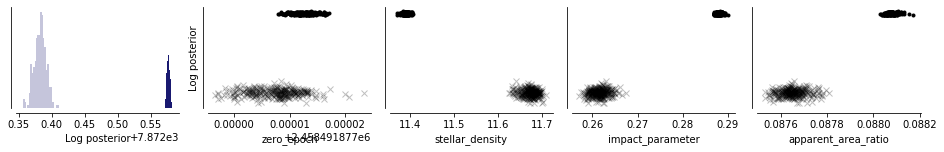

In [20]:
lpf.optimize_global(20000, npop=300)

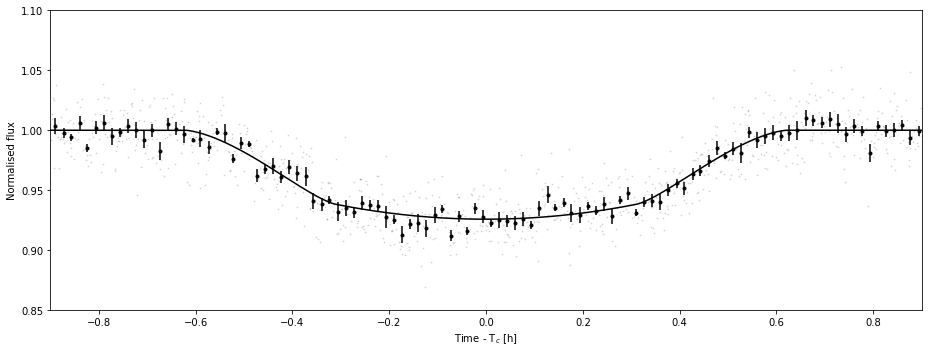

In [21]:
fig = lpf.plot_folded_tess_transit(figsize=(13,5), xlim=(-0.9, 0.9), ylim=(0.85, 1.1))

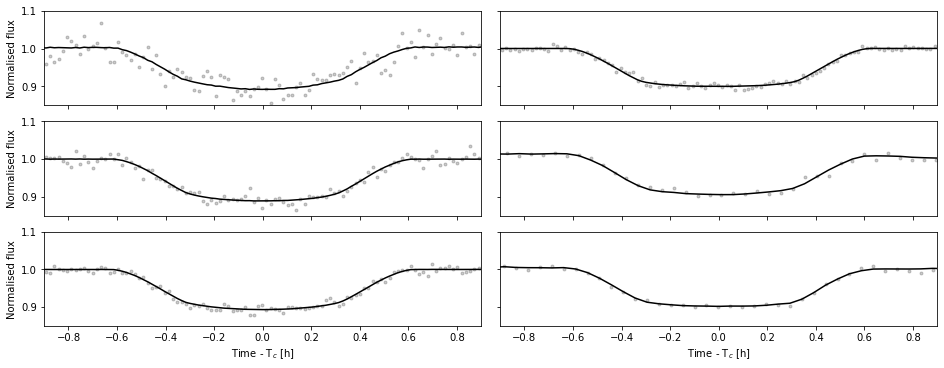

In [22]:
fig = lpf.plot_gb_transits(ncol=2, figsize=(13,5), xlim=(-0.9, 0.9), ylim=(0.85, 1.1))

### Sample the posterior

In [33]:
lpf.sample_mcmc(1000, 50, repeats=20)

In [34]:
lpf.sample_mcmc(10000, 100, repeats=1)

In [42]:
lpf.save()

In [39]:
df = lpf.posterior_samples()

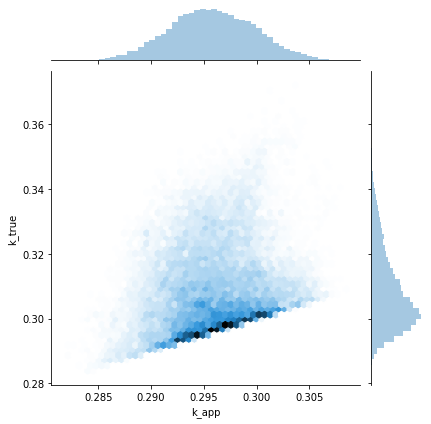

In [40]:
sb.jointplot(df.k_app, df.k_true, kind='hex')

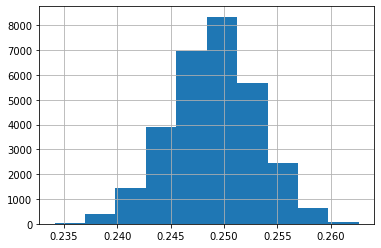

In [41]:
sqrt(df.k2_app_tess).hist()

---

<center>© 2020 Hannu Parviainen</center>